In [1]:
# store start time to get execution time of entire script
import time
start_time = time.time()

In [2]:
import numpy as np
np.random.seed(2017) # set random seed value to get reproducible results

In [3]:
from sklearn.model_selection import cross_validate
from sksurv.ensemble import RandomSurvivalForest
from tqdm.notebook import tqdm
import statistics

def n_permutations(n, rsf, feat, X, y):
    mean = 0
    std = 0
    for i in range(n):
        X[feat] = np.random.permutation(X[feat].values)        
        scores = cross_validate(rsf, X, y, cv=5)
        mean += scores['test_score'].mean()
        std += statistics.pstdev(scores['test_score'])
    #print('Feature:', feat, ' | Mean Score:', mean/n, ' | Standard Deviation:', std/n)
    return mean/n, std/n

def random_forest(X, y, label):
    # run model and cross validate to get concordance
    rsf = RandomSurvivalForest()
    
    scores = cross_validate(rsf, X, y, cv=5)
    concordance = scores['test_score'].mean()
    print('RF score:', concordance)
    
    # re-train model on full dataset
    rsf = RandomSurvivalForest()
    rsf.fit(X, y)
    
    # calculate feature importances
    feature_importance_rf = pd.DataFrame({'Feature':list(X.columns),})
    feature_importance_rf[label] = 0
        
    for i,row in tqdm(feature_importance_rf.iterrows(), total=feature_importance_rf.shape[0]):
        feat = row['Feature']
        temp_data = X.copy()
        temp_score, _ = n_permutations(5, rsf, feat, temp_data, y)
        percent_change = (concordance - temp_score) / concordance * 100 # percent change
        if percent_change < 0:
            percent_change = 0 # removing feature helped model, should not be reflected in feature importance
        feature_importance_rf.iloc[i, feature_importance_rf.columns.get_loc(label)] = percent_change
    
    # return scores and models
    return rsf, concordance, feature_importance_rf

//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 368 from PyObject
  return f(*args, **kwds)


In [4]:
def get_lasso_features(X):
    # one-hot encode all variables (except primsev) to get hazards across groups, drop reference group
    features_to_ignore = ['female','nonwhite','unemplmt_cd','primsev_alcohol','primsev_amphetamines',
                          'primsev_cocaine','primsev_marijuana','primsev_opioids','primsev_other']
    lasso_X = X.copy()
    
    for col in lasso_X.columns:
        if col not in features_to_ignore:
            one_hot = pd.get_dummies(lasso_X[col], prefix=col)
            one_hot = one_hot.loc[:, ~one_hot.columns.str.endswith('1')] # drop group and use as reference
            lasso_X = lasso_X.drop(col,axis = 1)
            lasso_X = lasso_X.join(one_hot)
    #print('Lasso Features:',lasso_X.columns)
    return lasso_X

In [5]:
from sksurv.linear_model import CoxnetSurvivalAnalysis

def lasso_regression(X, y, label):
    # l1_ratio = 1 adjusts model to implement LASSO method for penalties
    rcr = CoxnetSurvivalAnalysis(l1_ratio=1)
    
    scores = cross_validate(rcr, X, y, cv=5)
    concordance = scores['test_score'].mean()
    print('Lasso score:', concordance)
    
    # fit_baseline_model = True allows us to create survival/hazard plots after model is fit
    rcr = CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=1)
    rcr.fit(X, y)
    
    # feature importances from Lasso
    feature_importance_lasso = pd.DataFrame({'Feature':list(X.columns), 
                                                  label:np.average(rcr.coef_, weights=rcr.alphas_, axis = 1),})
    # convert regression coefficients to hazard ratios
    feature_importance_lasso[label] = np.exp(feature_importance_lasso[label])
    # rank by magnitude of deviation from 1
    feature_importance_lasso[label + '_adjusted'] = np.absolute(feature_importance_lasso[label]-1)
    
    return rcr, concordance, feature_importance_lasso

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 14

def get_survival_graph(rsf, rcr, X, lasso_X, y, label, filename):
    pred_surv_rsf = rsf.predict_survival_function(X)    
    pred_surv_rcr = rcr.predict_survival_function(lasso_X)
    
    # display survival plot
    plt.suptitle(label)
    plt.plot(np.mean([person for person in pred_surv_rsf], axis=0), label='RF')
    plt.plot(np.mean([person.y for person in pred_surv_rcr], axis=0), label='Lasso')
    labels, temp = get_ground_truth(y)
    plt.plot(labels, temp, label='Ground Truth')
    plt.legend()
    plt.xlim(0, 365)
    plt.xticks(np.arange(0, 365, step=50))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.savefig(filename)
        
    plt.show()

In [7]:
# helper function for plotting out ground truth curves

def get_ground_truth(data):
    relapsed = data[data.Illicit_Cens == 1]
    counts = relapsed['Illicit_Days'].value_counts()
    counts = counts.to_dict()
    temp = [len(data)] * 365
    labels = list(range(365))
    for i in range(365):
        labels[i] += 1
    total = 0
    errors = []
    for i in range(365):
        try:
            temp[i] = temp[i] - counts[i+1] - total
            total = total + counts[i+1]
        except KeyError:
            errors.append(i)

    for ele in sorted(errors, reverse = False):
        if ele != 0:
            temp[ele] = temp[ele-1]
        else:
             temp[0] = len(data)
    temp = [x / len(data) for x in temp]
    return labels, temp

In [8]:
# helper functions for displaying table data

import numpy as np
from IPython.display import display_html

# n is the number of columns to display data in
def display_side_by_side(series_obj, n):
    df = pd.DataFrame(series_obj)
    partition = int(round(len(df) / n))
    lower_bound = 0
    upper_bound = partition
    args = []
    for i in range(n):
        args.append(df[lower_bound:upper_bound])
        lower_bound += partition
        upper_bound += partition
    helper(args)

def helper(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

Survival Analysis by Severity

In [9]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import csv

df = pd.read_csv('../data/data_superset.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ID,State,City,agyaddr,xobsyr_0,Illicit_Days,Illicit_Cens,female,nonwhite,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,SUDSy_0_cd,homeless_0_cd,ncar_cd,TRIg_0_cd,PYS9Sxg_cd,primsev_other,primsev_alcohol,primsev_amphetamines,primsev_cocaine,primsev_marijuana,primsev_opioids,B2a_0g,Address,lat,lng,state_name,county_FIPS,block_FIPS,murder_numg,%_dropoutg,%_povertyg,%_public_assistanceg,%_unemployedg,closest,gran,point,pop_deng
0,0,4,6,21058,ID,Boise,8620 W. Emerald Street,2011,365,0,0,1,0,1,2,0,2,1,2,1,2,2,2,1,1,3,1,1,0,2,0,0,1,0,0,0,2,"8620 W. Emerald Street , B...",43.611373,-116.288882,Idaho,16001.0,1.600100e+14,0,0.0,0.0,0.0,0.0,"('39.523981', '-119.787921')",2.0,"('43.611373', '-116.288882')",0.0
1,1,5,7,12534,MI,Detroit,"1025 E. Forrest, Rm 408",2009,203,0,0,1,0,0,2,0,0,0,1,2,1,2,2,1,2,3,0,1,2,0,0,0,0,0,1,0,1,"1025 E. Forrest, Rm 408 , D...",42.359198,-83.051939,Michigan,26163.0,2.616352e+14,2,0.0,0.0,0.0,0.0,NaN,0.0,"('42.359198', '-83.051939')",0.0
2,2,7,9,14164,CO,Thornton,8801 Lipan Street,2008,96,1,1,1,1,1,2,0,1,2,1,1,1,2,1,0,2,3,0,1,0,0,0,1,0,0,0,0,1,"8801 Lipan Street , T...",39.858039,-105.001042,Colorado,8001.0,8.001009e+13,0,0.0,0.0,0.0,0.0,NaN,1.0,"('39.858039', '-105.001042')",0.0
3,3,8,10,18612,FL,Clearwater,315 Court Street,2009,51,1,1,0,1,0,1,0,1,1,0,0,0,2,2,0,2,1,0,1,0,0,0,1,0,0,0,0,2,"315 Court Street , C...",27.961606,-82.801244,Florida,12103.0,1.210303e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('27.9616065', '-82.80124359999999')",0.0
4,4,10,13,23871,WA,Seattle,401 Fifth Avenue,2012,213,0,1,0,0,1,2,0,2,1,0,0,2,2,2,1,2,3,0,0,1,0,0,0,1,0,0,0,1,"401 Fifth Avenue , S...",47.601714,-122.327658,Washington,53033.0,5.303301e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('47.601714', '-122.32765800000001')",0.0


In [10]:
# drop unnecessary columns
cols_to_drop = ['Address','lat','lng','xobsyr_0','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1',
                'ID','State','City','agyaddr','state_name','gran','county_FIPS','block_FIPS',
                'point','closest']

df.drop(columns=cols_to_drop, inplace=True)
df.dropna(inplace=True) # drops any remaining rows with null values

# uncomment to get CONTROL statistics
#cols_to_drop = ['pop_deng','%_dropoutg','%_unemployedg','%_public_assistanceg','%_povertyg','murder_numg']
#df.drop(columns=cols_to_drop, inplace=True)

df = df.astype(int)
df = df.sample(frac=1).reset_index(drop=True) # shuffle rows
df.shape

(10683, 35)

In [11]:
df["SUDSy_0_cd"].value_counts()

3    4354
1    3365
2    2964
Name: SUDSy_0_cd, dtype: int64

In [12]:
df.to_csv('../data/data_final.csv')
df.head()

,Illicit_Days,Illicit_Cens,female,nonwhite,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,SUDSy_0_cd,homeless_0_cd,ncar_cd,TRIg_0_cd,PYS9Sxg_cd,primsev_other,primsev_alcohol,primsev_amphetamines,primsev_cocaine,primsev_marijuana,primsev_opioids,B2a_0g,murder_numg,%_dropoutg,%_povertyg,%_public_assistanceg,%_unemployedg,pop_deng
0,87,0,0,1,0,0,1,0,2,1,1,1,1,2,1,0,0,2,0,1,0,0,0,0,0,0,1,0,1,2,0,0,0,0,0
1,177,0,0,1,0,0,0,0,0,0,0,0,0,1,2,2,0,1,0,1,0,0,0,0,0,0,1,0,1,2,0,0,0,0,1
2,50,1,0,0,0,1,2,0,1,1,1,1,0,1,1,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,365,0,0,0,0,1,0,0,1,0,2,2,0,1,1,0,0,3,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,79,1,0,0,0,1,2,0,1,1,0,2,2,1,2,2,0,3,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0


Full Population Analysis

In [13]:
from sksurv.util import Surv

predictor_var = 'Illicit_Days'
censoring_var = 'Illicit_Cens'

X = df.copy()
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var], inplace=True)
y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(10683, 33) (10683,)


In [14]:
%%time
full_rsf, full_rsf_score, full_rsf_feature_importance = random_forest(X, y, 'ALL')
full_rf_features = full_rsf_feature_importance[full_rsf_feature_importance.ALL >= 0.5]['Feature'].tolist()

RF score: 0.6565410884358579


Feature: female  | Mean Score: 0.6562735034680471  | Standard Deviation: 0.010272374893367648
Feature: nonwhite  | Mean Score: 0.6552512468942451  | Standard Deviation: 0.01050316931141828
Feature: unemplmt_cd  | Mean Score: 0.6554906364626522  | Standard Deviation: 0.009155431885969626
Feature: prsatx_cd  | Mean Score: 0.6551358218971833  | Standard Deviation: 0.010855263923736902
Feature: gvsg_cd  | Mean Score: 0.6559804958860784  | Standard Deviation: 0.009621740122472845
Feature: CWSg_0_cd  | Mean Score: 0.6560766790332533  | Standard Deviation: 0.010056847501335989
Feature: dssg_0_cd  | Mean Score: 0.6567397849479544  | Standard Deviation: 0.009640758985286815
Feature: epsg_0_cd  | Mean Score: 0.6554165634175302  | Standard Deviation: 0.008721861574753994
Feature: adhdg_0_cd  | Mean Score: 0.6554986721744941  | Standard Deviation: 0.010073376681753305
Feature: cdsg_0_cd  | Mean Score: 0.6575599932353848  | Standard Deviation: 0.009525633581271228
Feature: cjsig_0_cd  | Mean Score:

In [15]:
%%time
full_lasso_X = get_lasso_features(X[full_rf_features])
full_rcr, full_rcr_score, full_rcr_feature_importance = lasso_regression(full_lasso_X, y, 'ALL')

Lasso score: 0.6370887376103769
CPU times: user 2.11 s, sys: 170 ms, total: 2.28 s
Wall time: 1.25 s


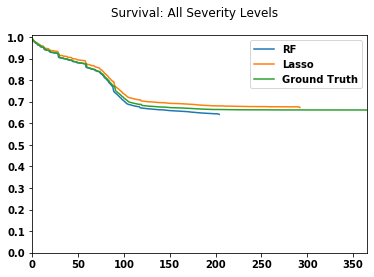

In [16]:
get_survival_graph(full_rsf, full_rcr, X, full_lasso_X, Y, 'Survival: All Severity Levels','../graphs/survival_all.png')

Subclinical Severity Analysis

In [17]:
X = df[df.SUDSy_0_cd == 1]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0_cd'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(3365, 32) (3365,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
%%time
sub_rsf, sub_rsf_score, sub_rsf_feature_importance = random_forest(X, y, 'SUB')
sub_rf_features = sub_rsf_feature_importance[sub_rsf_feature_importance.SUB >= 0.5]['Feature'].tolist()

RF score: 0.6441076361706678


Feature: female  | Mean Score: 0.6425056058287332  | Standard Deviation: 0.025238543266203346
Feature: nonwhite  | Mean Score: 0.6453564400076529  | Standard Deviation: 0.027105900668552608
Feature: unemplmt_cd  | Mean Score: 0.6451125599584812  | Standard Deviation: 0.02287602057911805
Feature: prsatx_cd  | Mean Score: 0.6458287784389268  | Standard Deviation: 0.024294236908180628
Feature: gvsg_cd  | Mean Score: 0.648845935123435  | Standard Deviation: 0.019876170917102746
Feature: CWSg_0_cd  | Mean Score: 0.6452334555215341  | Standard Deviation: 0.023499286727858733
Feature: dssg_0_cd  | Mean Score: 0.6439116196574007  | Standard Deviation: 0.027457616084832902
Feature: epsg_0_cd  | Mean Score: 0.6470883004762047  | Standard Deviation: 0.022381542636206758
Feature: adhdg_0_cd  | Mean Score: 0.6424233913585686  | Standard Deviation: 0.023927095785875246
Feature: cdsg_0_cd  | Mean Score: 0.6469539489220161  | Standard Deviation: 0.024592411607652902
Feature: cjsig_0_cd  | Mean Score: 

In [19]:
%%time
sub_lasso_X = get_lasso_features(X[sub_rf_features])
sub_rcr, sub_rcr_score, sub_rcr_feature_importance = lasso_regression(sub_lasso_X, y, 'SUB')

Lasso score: 0.6384315762498596
CPU times: user 582 ms, sys: 36 ms, total: 618 ms
Wall time: 419 ms


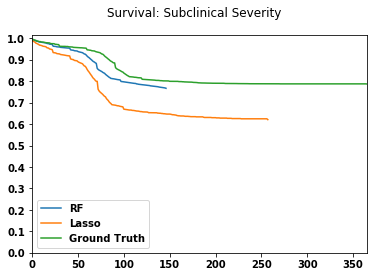

In [20]:
get_survival_graph(sub_rsf, sub_rcr, X, sub_lasso_X, Y, 'Survival: Subclinical Severity','../graphs/survival_sub.png')

Mild Severity Analysis

In [21]:
X = df[df.SUDSy_0_cd == 2]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0_cd'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(2964, 32) (2964,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
%%time
mild_rsf, mild_rsf_score, mild_rsf_feature_importance = random_forest(X, y, 'MILD')
mild_rf_features = mild_rsf_feature_importance[mild_rsf_feature_importance.MILD >= 0.5]['Feature'].tolist()

RF score: 0.5721986006542348


Feature: female  | Mean Score: 0.5710776959266479  | Standard Deviation: 0.01685234562646005
Feature: nonwhite  | Mean Score: 0.5729075997315718  | Standard Deviation: 0.018356872488214958
Feature: unemplmt_cd  | Mean Score: 0.5713738421962062  | Standard Deviation: 0.015711830361869093
Feature: prsatx_cd  | Mean Score: 0.5678307902763275  | Standard Deviation: 0.01613018858591899
Feature: gvsg_cd  | Mean Score: 0.5708654571700362  | Standard Deviation: 0.017427436631798056
Feature: CWSg_0_cd  | Mean Score: 0.57317000721955  | Standard Deviation: 0.014214740708347103
Feature: dssg_0_cd  | Mean Score: 0.5748871791433006  | Standard Deviation: 0.015911036806165523
Feature: epsg_0_cd  | Mean Score: 0.5720744888820667  | Standard Deviation: 0.015700645898094296
Feature: adhdg_0_cd  | Mean Score: 0.5727860611208978  | Standard Deviation: 0.015889790964528385
Feature: cdsg_0_cd  | Mean Score: 0.5743486296626388  | Standard Deviation: 0.015647734755678006
Feature: cjsig_0_cd  | Mean Score: 0.

In [23]:
%%time
mild_lasso_X = get_lasso_features(X[mild_rf_features])
mild_rcr, mild_rcr_score, mild_rcr_feature_importance = lasso_regression(mild_lasso_X, y, 'MILD')

Lasso score: 0.5703438251264071
CPU times: user 589 ms, sys: 34.3 ms, total: 623 ms
Wall time: 395 ms


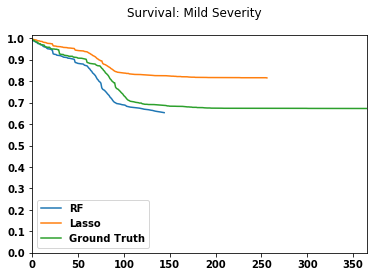

In [24]:
get_survival_graph(mild_rsf, mild_rcr, X, mild_lasso_X, Y, 'Survival: Mild Severity','../graphs/survival_mild.png')

Severe Severity Analysis

In [25]:
X = df[df.SUDSy_0_cd == 3]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0_cd'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(4354, 32) (4354,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
%%time
severe_rsf, severe_rsf_score, severe_rsf_feature_importance = random_forest(X, y, 'SEVERE')
severe_rf_features = severe_rsf_feature_importance[severe_rsf_feature_importance.SEVERE >= 0.5]['Feature'].tolist()

RF score: 0.6037988668591601


Feature: female  | Mean Score: 0.6055035650165507  | Standard Deviation: 0.007226953302083676
Feature: nonwhite  | Mean Score: 0.6007309835091578  | Standard Deviation: 0.005303853129828792
Feature: unemplmt_cd  | Mean Score: 0.6032562389018616  | Standard Deviation: 0.007870758090051479
Feature: prsatx_cd  | Mean Score: 0.6052936579248369  | Standard Deviation: 0.01219884041478421
Feature: gvsg_cd  | Mean Score: 0.6038368818843944  | Standard Deviation: 0.00826550907396699
Feature: CWSg_0_cd  | Mean Score: 0.6020355875093826  | Standard Deviation: 0.005483076356571873
Feature: dssg_0_cd  | Mean Score: 0.6048084860990833  | Standard Deviation: 0.008419467025194504
Feature: epsg_0_cd  | Mean Score: 0.6041622254382752  | Standard Deviation: 0.005530512966290395
Feature: adhdg_0_cd  | Mean Score: 0.6050138643995193  | Standard Deviation: 0.008607269865381337
Feature: cdsg_0_cd  | Mean Score: 0.6075765862027346  | Standard Deviation: 0.0074133842342242115
Feature: cjsig_0_cd  | Mean Score:

In [27]:
%%time
severe_lasso_X = get_lasso_features(X[severe_rf_features])
severe_rcr, severe_rcr_score, severe_rcr_feature_importance = lasso_regression(severe_lasso_X, y, 'SEVERE')

Lasso score: 0.5790972274392399
CPU times: user 338 ms, sys: 54.7 ms, total: 392 ms
Wall time: 497 ms


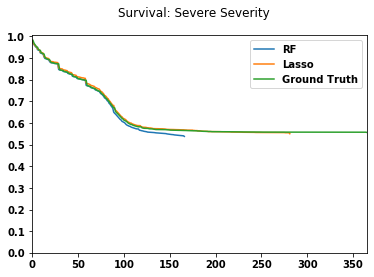

In [28]:
get_survival_graph(severe_rsf, severe_rcr, X, severe_lasso_X, Y, 'Survival: Severe Severity','../graphs/survival_severe.png')

Overall Statistics

In [29]:
# concordance index
scores = {'MODEL': ['Random Forest','Lasso','Dataset Size'], 
          'SUB': [sub_rsf_score,sub_rcr_score,int(sub_lasso_X.shape[0])],
          'MILD': [mild_rsf_score,mild_rcr_score,int(mild_lasso_X.shape[0])],
          'SEVERE': [severe_rsf_score,severe_rcr_score,int(severe_lasso_X.shape[0])],
          'FULL': [full_rsf_score,full_rcr_score,int(full_lasso_X.shape[0])]
         }
overall_concordance = pd.DataFrame(data=scores).round(4)
overall_concordance

,MODEL,SUB,MILD,SEVERE,FULL
0,Random Forest,0.6441,0.5722,0.6038,0.6565
1,Lasso,0.6384,0.5703,0.5791,0.6371
2,Dataset Size,3365.0000,2964.0000,4354.0000,10683.0000


In [30]:
overall_feature_importance_lasso = pd.merge(sub_rcr_feature_importance, \
                                            mild_rcr_feature_importance, on='Feature', how='outer')
overall_feature_importance_lasso = pd.merge(overall_feature_importance_lasso, \
                                            severe_rcr_feature_importance, on='Feature', how='outer')
overall_feature_importance_lasso.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_lasso, 2)

,Feature,SUB,SUB_adjusted,MILD,MILD_adjusted,SEVERE,SEVERE_adjusted
0,cjsig_0_cd_0,0.919541,0.080459,0.937134,0.062866,0.000000,0.000000
1,cjsig_0_cd_2,1.080509,0.080509,0.997540,0.002460,0.000000,0.000000
2,r4ag_0_cd_0,0.982394,0.017606,0.881550,0.118450,0.934462,0.065538
3,r4ag_0_cd_2,1.198671,0.198671,0.999651,0.000349,1.000000,0.000000
4,B2a_0g_0,0.947657,0.052343,0.986842,0.013158,1.000000,0.000000
5,B2a_0g_2,1.135208,0.135208,0.965210,0.034790,1.000000,0.000000
6,murder_numg_0,1.452005,0.452005,0.000000,0.000000,0.000000,0.000000
7,murder_numg_2,1.000003,0.000003,0.000000,0.000000,0.000000,0.000000
,Feature,SUB,SUB_adjusted,MILD,MILD_adjusted,SEVERE,SEVERE_adjusted
8,%_povertyg_0,0.946421,0.053579,0.982812,1.718818e-02,1.000000,0.000000


In [31]:
sub_feature_importance_lasso = sub_rcr_feature_importance.nlargest(10,['SUB_adjusted'])
mild_feature_importance_lasso = mild_rcr_feature_importance.nlargest(10,['MILD_adjusted'])
severe_feature_importance_lasso = severe_rcr_feature_importance.nlargest(10,['SEVERE_adjusted'])

top10_feature_importance_lasso = pd.merge(sub_feature_importance_lasso, \
                                            mild_feature_importance_lasso, on='Feature', how='outer')
top10_feature_importance_lasso = pd.merge(top10_feature_importance_lasso, \
                                            severe_feature_importance_lasso, on='Feature', how='outer')
top10_feature_importance_lasso.fillna(0, inplace=True)
display_side_by_side(top10_feature_importance_lasso, 2)

,Feature,SUB,SUB_adjusted,MILD,MILD_adjusted,SEVERE,SEVERE_adjusted
0,murder_numg_0,1.452005,0.452005,0.000000,0.000000,0.000000,0.000000
1,r4ag_0_cd_2,1.198671,0.198671,0.000000,0.000000,1.000000,0.000000
2,B2a_0g_2,1.135208,0.135208,0.965210,0.034790,1.000000,0.000000
3,cjsig_0_cd_2,1.080509,0.080509,0.997540,0.002460,0.000000,0.000000
4,cjsig_0_cd_0,0.919541,0.080459,0.937134,0.062866,0.000000,0.000000
5,%_povertyg_0,0.946421,0.053579,0.982812,0.017188,1.000000,0.000000
6,B2a_0g_0,0.947657,0.052343,0.986842,0.013158,1.000000,0.000000
7,r4ag_0_cd_0,0.982394,0.017606,0.881550,0.118450,0.934462,0.065538
,Feature,SUB,SUB_adjusted,MILD,MILD_adjusted,SEVERE,SEVERE_adjusted
8,murder_numg_2,1.000003,0.000003,0.000000,0.000000,0.000000,0.000000


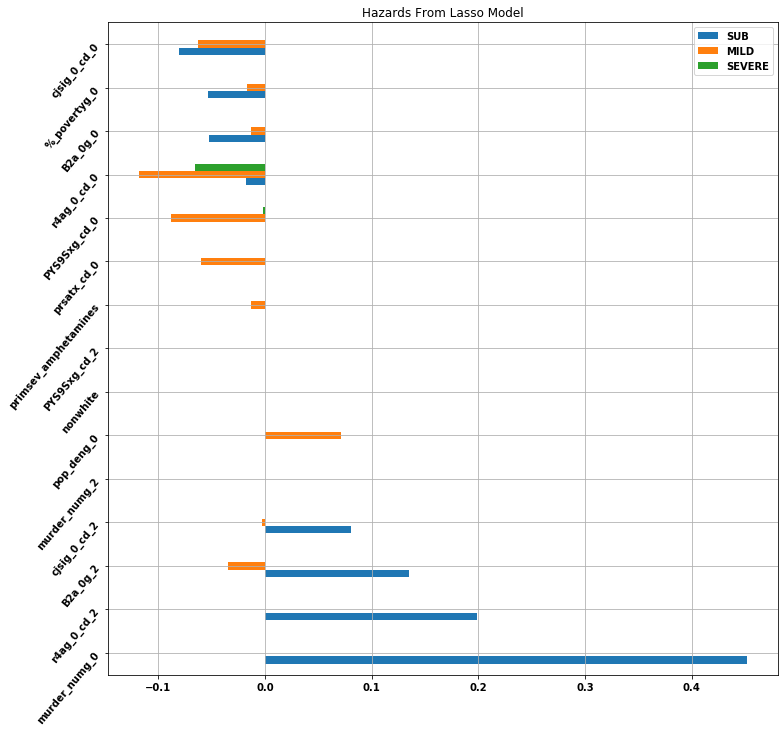

In [32]:
top10_feature_importance_lasso['SUB_minus1'] = top10_feature_importance_lasso['SUB'] - 1
top10_feature_importance_lasso['MILD_minus1'] = top10_feature_importance_lasso['MILD'] - 1
top10_feature_importance_lasso['SEVERE_minus1'] = top10_feature_importance_lasso['SEVERE'] - 1

haz_df = pd.DataFrame({'SUB': top10_feature_importance_lasso['SUB_minus1'].tolist(),
                   'MILD': top10_feature_importance_lasso['MILD_minus1'].tolist(),
                   'SEVERE': top10_feature_importance_lasso['SEVERE_minus1'].tolist()},
                  index=top10_feature_importance_lasso['Feature'].tolist())
haz_df = haz_df.replace(-1, 0)
haz_df.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = haz_df.plot.barh(rot=50, figsize=(12, 12))
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('../graphs/hazards_lasso.png', bbox_inches='tight')

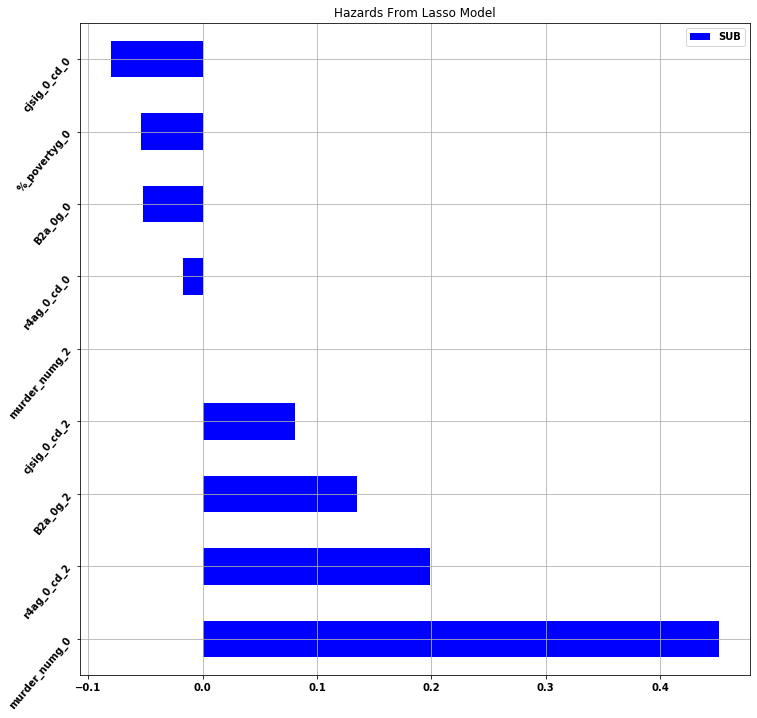

In [33]:
haz_sub = pd.DataFrame({'SUB': top10_feature_importance_lasso['SUB_minus1'].tolist()},
                  index=top10_feature_importance_lasso['Feature'].tolist())
haz_sub = haz_sub[haz_sub.SUB != -1]
haz_sub.sort_values(by=['SUB'], ascending=False, inplace=True)

ax = haz_sub.plot.barh(rot=50, figsize=(12, 12), color='blue')
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('../graphs/hazards_lasso_sub.png', bbox_inches='tight')

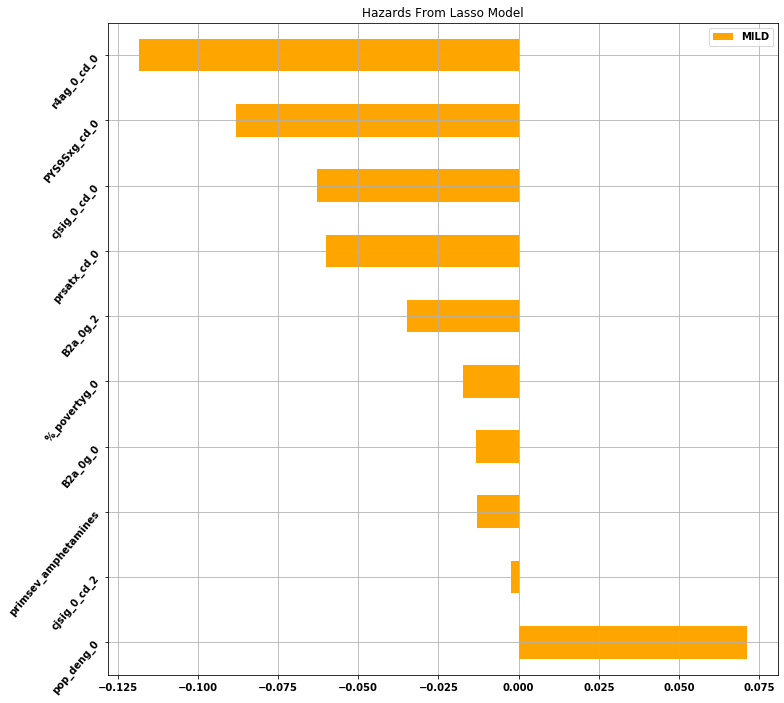

In [34]:
haz_mild = pd.DataFrame({'MILD': top10_feature_importance_lasso['MILD_minus1'].tolist()},
                  index=top10_feature_importance_lasso['Feature'].tolist())
haz_mild = haz_mild[haz_mild.MILD != -1]
haz_mild.sort_values(by=['MILD'], ascending=False, inplace=True)

ax = haz_mild.plot.barh(rot=50, figsize=(12, 12), color='orange')
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('../graphs/hazards_lasso_mild.png', bbox_inches='tight')

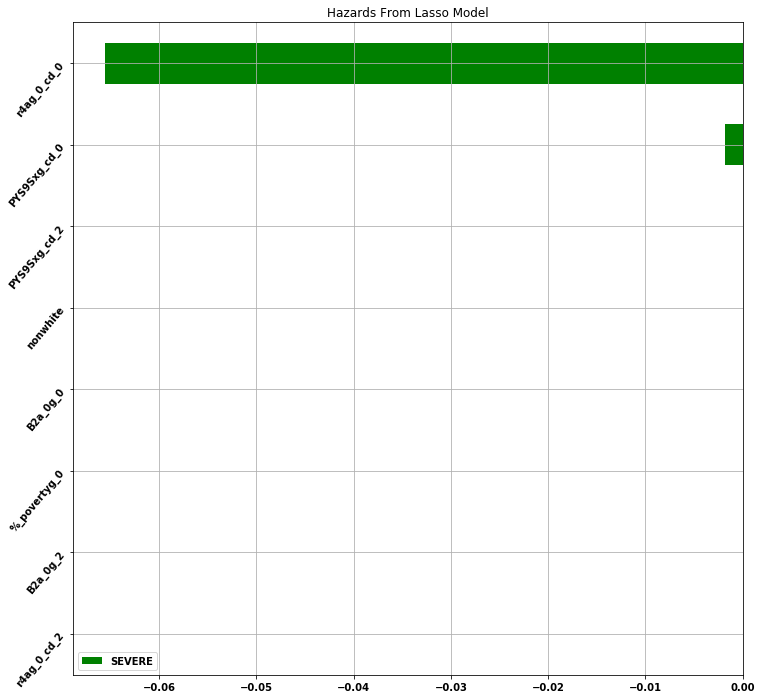

In [35]:
haz_severe = pd.DataFrame({'SEVERE': top10_feature_importance_lasso['SEVERE_minus1'].tolist()},
                  index=top10_feature_importance_lasso['Feature'].tolist())
haz_severe = haz_severe[haz_severe.SEVERE != -1]
haz_severe.sort_values(by=['SEVERE'], ascending=False, inplace=True)

ax = haz_severe.plot.barh(rot=50, figsize=(12, 12), color='green')
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('../graphs/hazards_lasso_severe.png', bbox_inches='tight')

In [36]:
overall_feature_importance_rf = pd.merge(sub_rsf_feature_importance, mild_rsf_feature_importance, on='Feature', how='outer')
overall_feature_importance_rf = pd.merge(overall_feature_importance_rf, severe_rsf_feature_importance, on='Feature', how='outer')
overall_feature_importance_rf.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_rf, 4)

,Feature,SUB,MILD,SEVERE
0,female,0.248721,0.195894,0.000000
1,nonwhite,0.000000,0.000000,0.508097
2,unemplmt_cd,0.000000,0.144138,0.089869
3,prsatx_cd,0.000000,0.763338,0.000000
4,gvsg_cd,0.000000,0.232986,0.000000
5,CWSg_0_cd,0.000000,0.000000,0.292031
6,dssg_0_cd,0.030432,0.000000,0.000000
7,epsg_0_cd,0.000000,0.021690,0.000000
,Feature,SUB,MILD,SEVERE
8,adhdg_0_cd,0.261485,0.000000,0.000000


In [37]:
sub_feature_importance_rf = sub_rsf_feature_importance.nlargest(10,['SUB'])
mild_feature_importance_rf = mild_rsf_feature_importance.nlargest(10,['MILD'])
severe_feature_importance_rf = severe_rsf_feature_importance.nlargest(10,['SEVERE'])

top10_feature_importance_rf = pd.merge(sub_feature_importance_rf, mild_feature_importance_rf, on='Feature', how='outer')
top10_feature_importance_rf = pd.merge(top10_feature_importance_rf, severe_feature_importance_rf, on='Feature', how='outer')
top10_feature_importance_rf.fillna(0, inplace=True)
display_side_by_side(top10_feature_importance_rf, 4)

,Feature,SUB,MILD,SEVERE
0,murder_numg,1.771491,0.000000,0.000000
1,cjsig_0_cd,1.428076,0.850552,0.000000
2,r4ag_0_cd,1.328179,0.582188,1.005755
3,B2a_0g,0.918372,0.641662,1.848720
4,%_povertyg,0.874007,1.130338,0.842004
,Feature,SUB,MILD,SEVERE
5,ncar_cd,0.423631,0.0,0.000000
6,adhdg_0_cd,0.261485,0.0,0.000000
7,female,0.248721,0.0,0.000000
8,dssg_0_cd,0.030432,0.0,0.000000


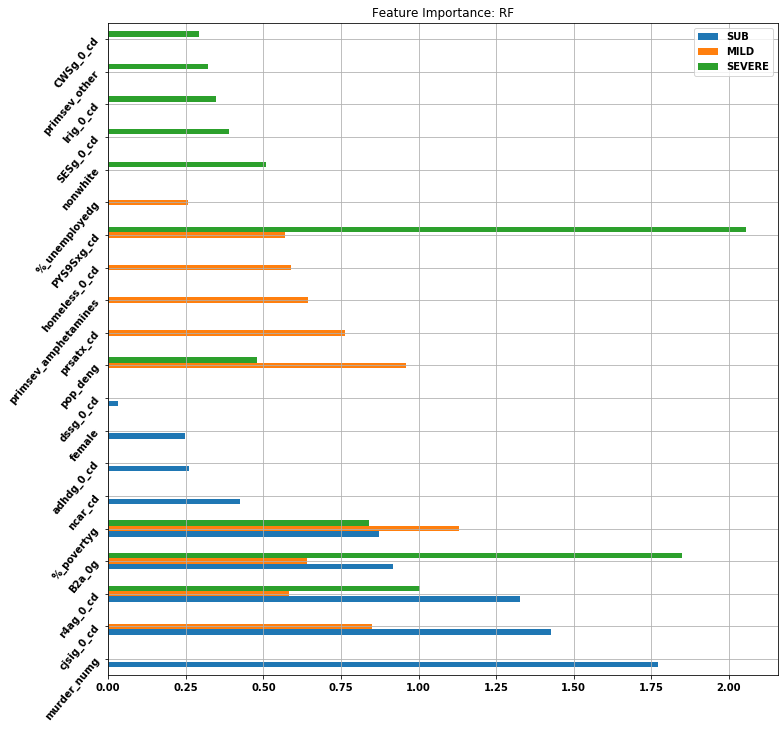

In [38]:
# feature importance for rf across all ages
feature_importance = pd.DataFrame({'SUB': top10_feature_importance_rf['SUB'].tolist(),
                   'MILD': top10_feature_importance_rf['MILD'].tolist(),
                   'SEVERE': top10_feature_importance_rf['SEVERE'].tolist()},
                  index=top10_feature_importance_rf['Feature'].tolist())
# John asked to sort this graph by MILD
feature_importance.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = feature_importance.plot.barh(rot=50, figsize=(12, 12))
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('../graphs/feature_importance.png', bbox_inches='tight')

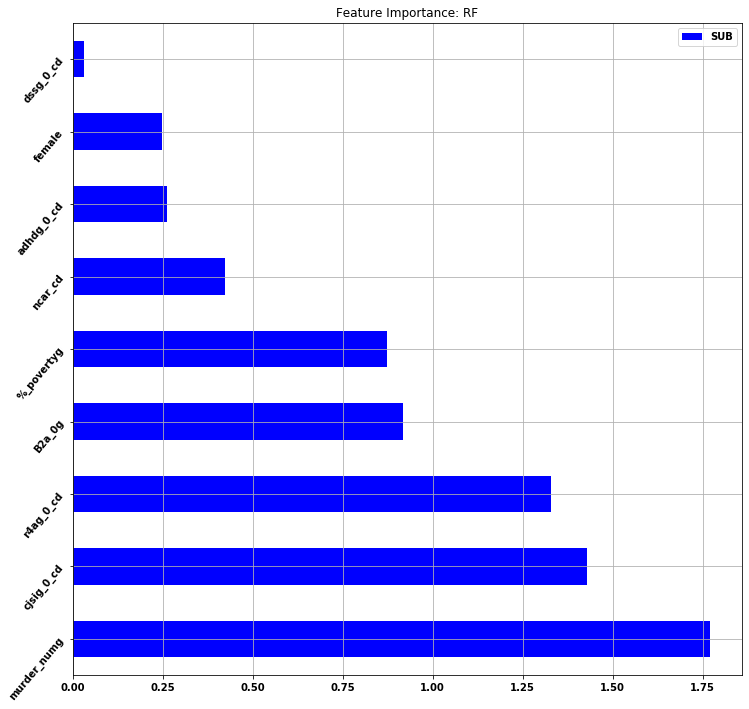

In [39]:
# feature importance for rf across all ages
feature_importance_sub = pd.DataFrame({'SUB': top10_feature_importance_rf['SUB'].tolist()},
                  index=top10_feature_importance_rf['Feature'].tolist())
feature_importance_sub = feature_importance_sub[feature_importance_sub.SUB != 0]
# John asked to sort this graph by MILD
feature_importance_sub.sort_values(by=['SUB'], ascending=False, inplace=True)
ax = feature_importance_sub.plot.barh(rot=50, figsize=(12, 12), color='blue')
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('../graphs/feature_importance_sub.png', bbox_inches='tight')

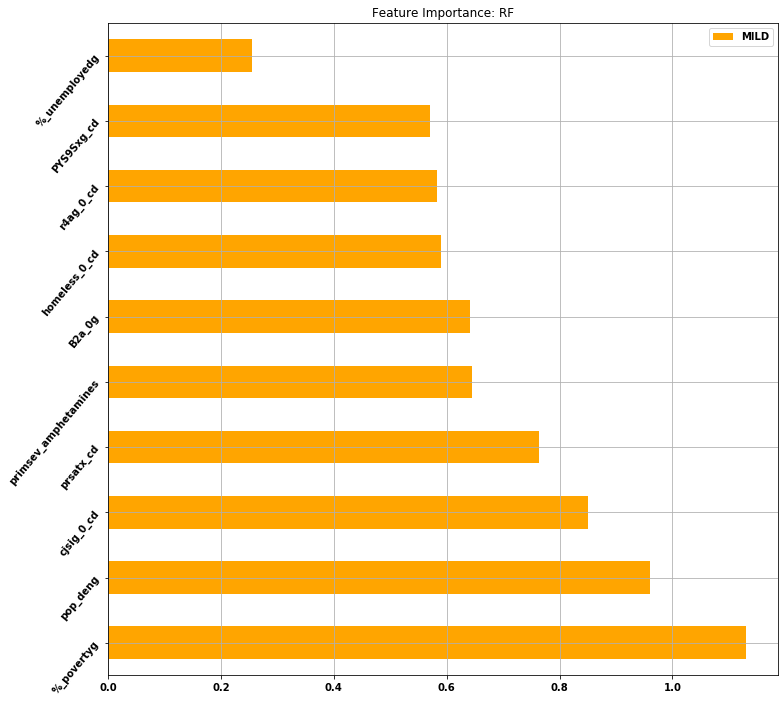

In [40]:
# feature importance for rf across all ages
feature_importance_mild = pd.DataFrame({'MILD': top10_feature_importance_rf['MILD'].tolist()},
                  index=top10_feature_importance_rf['Feature'].tolist())
feature_importance_mild = feature_importance_mild[feature_importance_mild.MILD != 0]
# John asked to sort this graph by MILD
feature_importance_mild.sort_values(by=['MILD'], ascending=False, inplace=True)
ax = feature_importance_mild.plot.barh(rot=50, figsize=(12, 12), color='orange')
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('../graphs/feature_importance_mild.png', bbox_inches='tight')

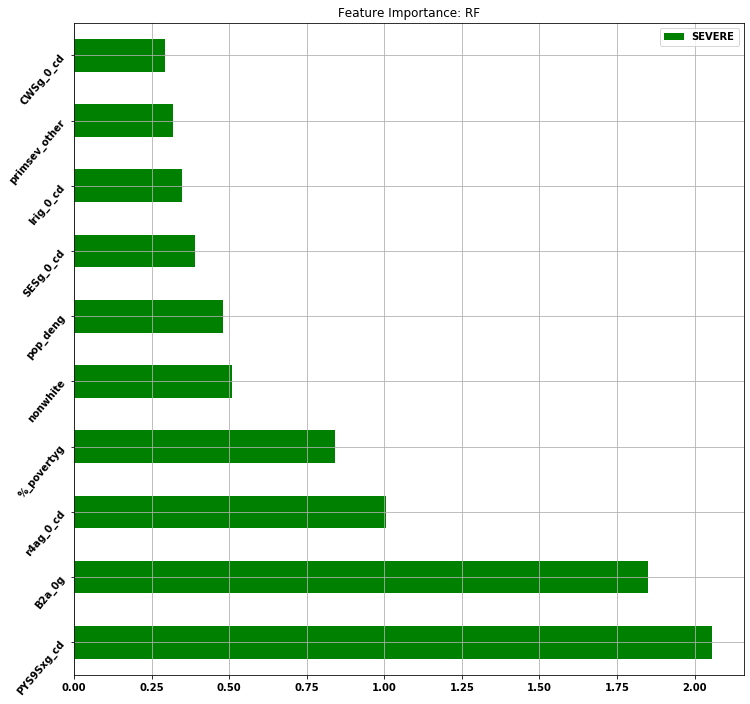

In [41]:
# feature importance for rf across all ages
feature_importance_severe = pd.DataFrame({'SEVERE': top10_feature_importance_rf['SEVERE'].tolist()},
                  index=top10_feature_importance_rf['Feature'].tolist())
feature_importance_severe = feature_importance_severe[feature_importance_severe.SEVERE != 0]
# John asked to sort this graph by MILD
feature_importance_severe.sort_values(by=['SEVERE'], ascending=False, inplace=True)
ax = feature_importance_severe.plot.barh(rot=50, figsize=(12, 12), color='green')
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('../graphs/feature_importance_severe.png', bbox_inches='tight')

In [42]:
# all features in both models across all severity groups
rf = overall_feature_importance_rf['Feature'].tolist()
lasso = overall_feature_importance_lasso['Feature'].tolist()

common_features = []
lasso_common_features = []

for elem_rf in rf:
    for elem_lasso in lasso:
        if elem_lasso.startswith(elem_rf):
            common_features.append(elem_rf)
            lasso_common_features.append(elem_lasso)

common_features = list(set(common_features))
lasso_common_features = list(set(lasso_common_features))

In [43]:
def lasso_level_winner(feat, lasso_0, lasso_2):
    bin_features = ['female','nonwhite','unemplmt_cd','primsev_alcohol','primsev_amphetamines',
                          'primsev_cocaine','primsev_marijuana','primsev_opioids','primsev_other']
    if lasso_0 == 0 and lasso_2 == 0: # removed bc RF deemed unimportant
        return pd.Series((0, '-'))
    if feat in bin_features: # binary feature
        return pd.Series((lasso_0, '2'))
    if lasso_0 == 0:
        return pd.Series((lasso_2, '0'))
    if lasso_2 == 0:
        return pd.Series((lasso_0, '0'))
    lasso_0_min1 = np.absolute(lasso_0 - 1)
    lasso_2_min1 = np.absolute(lasso_2 - 1)
    if lasso_0_min1 > lasso_2_min1:
        return pd.Series((lasso_0, '0'))
    else:
        return pd.Series((lasso_2, '2'))

In [44]:
def analyze_common_features(subgroup):
    global common_features
    global lasso_common_features
    
    data = []

    for feat in common_features:
        temp = []
        temp.append(feat)
        temp.append(float(overall_feature_importance_rf.loc[overall_feature_importance_rf['Feature'] == feat, subgroup]))
        for i,row in overall_feature_importance_lasso.iterrows():
            if row['Feature'].startswith(feat):
                temp.append(row[subgroup])
        data.append(temp)

    df = pd.DataFrame(data=data, columns=['Feature', 'RF', 'Lasso_0', 'Lasso_2'])
    df = df.fillna(0)
    df[['max', 'winner']] = df.apply(lambda x: lasso_level_winner(x['Feature'], x['Lasso_0'], x['Lasso_2']), axis=1)
    
    return df

In [45]:
sub_cmn_feat = analyze_common_features('SUB')
sub_cmn_feat

,Feature,RF,Lasso_0,Lasso_2,max,winner
0,murder_numg,1.771491,1.452005,1.000003,1.452005,0
1,r4ag_0_cd,1.328179,0.982394,1.198671,1.198671,2
2,primsev_amphetamines,0.000000,0.000000,0.000000,0.000000,-
3,homeless_0_cd,0.000000,0.000000,0.000000,0.000000,-
4,PYS9Sxg_cd,0.000000,0.000000,0.000000,0.000000,-
5,cjsig_0_cd,1.428076,0.919541,1.080509,1.080509,2
6,prsatx_cd,0.000000,0.000000,0.000000,0.000000,-
7,%_povertyg,0.874007,0.946421,0.000000,0.946421,0
8,pop_deng,0.000000,0.000000,0.000000,0.000000,-
9,B2a_0g,0.918372,0.947657,1.135208,1.135208,2


In [46]:
mild_cmn_feat = analyze_common_features('MILD')
mild_cmn_feat

,Feature,RF,Lasso_0,Lasso_2,max,winner
0,murder_numg,0.169866,0.000000,0.000000,0.000000,-
1,r4ag_0_cd,0.582188,0.881550,0.999651,0.881550,0
2,primsev_amphetamines,0.645295,0.987114,0.000000,0.987114,2
3,homeless_0_cd,0.590613,1.000000,0.000000,1.000000,0
4,PYS9Sxg_cd,0.570654,0.911912,1.000000,0.911912,0
5,cjsig_0_cd,0.850552,0.937134,0.997540,0.937134,0
6,prsatx_cd,0.763338,0.939959,0.000000,0.939959,0
7,%_povertyg,1.130338,0.982812,0.000000,0.982812,0
8,pop_deng,0.960552,1.071305,1.000000,1.071305,0
9,B2a_0g,0.641662,0.986842,0.965210,0.965210,2


In [47]:
severe_cmn_feat = analyze_common_features('SEVERE')
severe_cmn_feat

,Feature,RF,Lasso_0,Lasso_2,max,winner
0,murder_numg,0.089810,0.000000,0.0,0.000000,-
1,r4ag_0_cd,1.005755,0.934462,1.0,0.934462,0
2,primsev_amphetamines,0.000000,0.000000,0.0,0.000000,-
3,homeless_0_cd,0.000000,0.000000,0.0,0.000000,-
4,PYS9Sxg_cd,2.055063,0.998177,1.0,0.998177,0
5,cjsig_0_cd,0.082819,0.000000,0.0,0.000000,-
6,prsatx_cd,0.000000,0.000000,0.0,0.000000,-
7,%_povertyg,0.842004,1.000000,0.0,1.000000,0
8,pop_deng,0.479944,0.000000,0.0,0.000000,-
9,B2a_0g,1.848720,1.000000,1.0,1.000000,2


In [48]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('../graphs/common_feature_analysis.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
sub_cmn_feat.to_excel(writer, sheet_name='Subclinical')
mild_cmn_feat.to_excel(writer, sheet_name='Mild')
severe_cmn_feat.to_excel(writer, sheet_name='Severe')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [49]:
# print out total notebook execution time
total_seconds = int(time.time() - start_time)
minutes = total_seconds // 60
seconds = total_seconds % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 182 minutes 22 seconds ---
